# RealNVP

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1),
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as sk_datasets

import jax
import jax.numpy as jnp

import flax.linen as nn

## 0. Training Parameters

In [44]:
NUM_SAMPLES = 30_000
COULPING_LAYERS = 6

INPUT_DIM = 2
HIDDEN_DIM = 256
REGULARIZATION = 1e-3
BATCH_SIZE = 256
EPOCHS = 100

# kwargs for model's tabulate function
console_kwargs = {"width": 100, 
                  "force_terminal": False, 
                  "force_jupyter": True,
                  "soft_wrap": True}

## 1. Preparing Moon dataset

The shape of moon dataset:  (30000, 2)


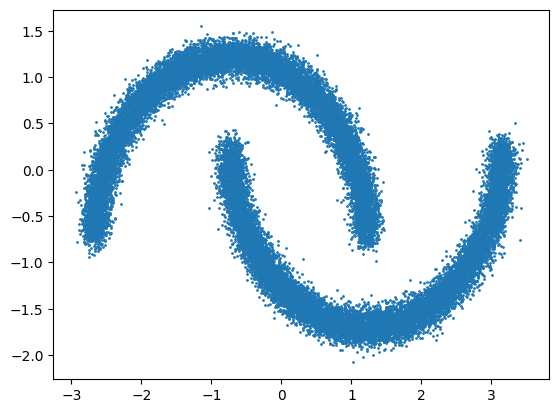

In [45]:
data = sk_datasets.make_moons(n_samples=NUM_SAMPLES, noise=5e-2)[0].astype("float32")
print("The shape of moon dataset: ", data.shape)
# data normalization
mean = data.mean()
std = data.std()
moon_data = (data - mean) / (std ** 2)
# visualize dataset
plt.scatter(moon_data[:, 0], moon_data[:, 1], s=1.0)
plt.show()

## 2. Building RealNVP

Building backbone layer

In [46]:
class Coupling(nn.Module):
    
    last_activation:bool = True
    n_layers:int = 5
    dims:tuple = tuple([HIDDEN_DIM] * (n_layers - 1) + [INPUT_DIM])
    
    def setup(self):
        layers = []
        for i in range(self.n_layers):
            layers.append(nn.Dense(features=self.dims[i]))
            if i != (self.n_layers - 1):
                layers.append(nn.relu)
        if self.last_activation:
            layers.append(nn.tanh)
        self.network = nn.Sequential(layers)

    def __call__(self, x):
        return self.network(x)

In [47]:
print(Coupling().tabulate(jax.random.PRNGKey(0), 
                  jnp.ones((10, 2)), 
                  console_kwargs=console_kwargs))

                                        Coupling Summary                                        
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path             ┃ module     ┃ inputs          ┃ outputs         ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  │ Coupling   │ float32[10,2]   │ float32[10,2]   │                          │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network          │ Sequential │ float32[10,2]   │ float32[10,2]   │                          │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_0 │ Dense      │ float32[10,2]   │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[2,256]   │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 768 (3.1 KB)             │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_2 │ Dense      │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[256,256] │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_4 │ Dense      │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[256,256] │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_6 │ Dense      │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[256,256] │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_8 │ Dense      │ float32[10,256] │ float32[10,2]   │ bias: float32[2]         │
│                  │            │                 │                 │ kernel: float32[256,2]   │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 514 (2.1 KB)             │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│                  │            │                 │           Total │ 198,658 (794.6 KB)       │
└──────────────────┴────────────┴─────────────────┴─────────────────┴──────────────────────────┘
                                                                                                
                              Total Parameters: 198,658 (794.6 KB)                              

In [48]:
class RealNVP(nn.Module):
    num_couplings = COULPING_LAYERS

    def setup(self):
        self.mask = np.array([[0, 1], [1, 0]] * (self.num_couplings // 2), dtype=np.float32)
        self.t = [Coupling(last_activation=None) for i in range(self.num_couplings)]
        self.s = [Coupling() for i in range(self.num_couplings)]
    
    def __call__(self, x, training=True):
        log_det_inv = np.zeros_like(x.shape[0])
        (start, end, step) = (self.num_couplings -1 , -1, -1) if training else (0, self.num_couplings, 1)
        
        z = x
        for i in range(start, end, step):
            z_masked = z * self.mask[i]
            s = self.s[i](z_masked) * (1 - self.mask[i])
            t = self.t[i](z_masked) * (1 - self.mask[i])
            if training:
                z = z_masked + (1 - self.mask[i]) * (z - t) * jnp.exp(-s)
                log_det_inv -= jnp.sum(s, axis=-1)
            else:
                z = z_masked + (1 - self.mask[i]) * (x * jnp.exp(s) + t)
        return z, log_det_inv

In [52]:
print(RealNVP().tabulate(jax.random.PRNGKey(0),
                  jnp.ones((10, 2)), 
                  training=True,
                  depth=2,
                  console_kwargs=console_kwargs))

                                   RealNVP Summary                                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module     ┃ inputs           ┃ outputs         ┃ params             ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│             │ RealNVP    │ - float32[10,2]  │ - float32[10,2] │                    │
│             │            │ - training: True │ - float32[10]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_5         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_5/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_5         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_5/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_4         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_4/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_4         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_4/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_3         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_3/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_3         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_3/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_2         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_2/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_2         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_2/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_1         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_1/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_1         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_1/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) 